In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# data preprocessing
import nltk
from nltk import word_tokenize , sent_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import re
from sklearn.preprocessing import LabelEncoder

# Word Cloud
from wordcloud import WordCloud
from collections import Counter

# model building
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [9]:
df= pd.read_csv('/content/drive/MyDrive/Data Science and Analytics/Projects /OASIS Infobyte/Datasets/spam.csv', encoding='ISO-8859-1')

In [10]:
# checking the dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [11]:
# Taking a first glance at the dataframe
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### DATA CLEANING

In [12]:
# checking the percentage of null values
round(df.isna().sum()/df.shape[0],2)

,0
v1,0.00
v2,0.00
Unnamed: 2,0.99
Unnamed: 3,1.00
Unnamed: 4,1.00


__The Unnamed:2, 3 & 4 columns contain over 99% null values, and as a result, they'll be dropped__

In [13]:
# drop columns "Unnamed:2", "Unnamed:3" and "Unnamed:4"
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'], inplace=True)

In [14]:
#checking duplicated entries
print(f'The dataset contains {df.duplicated().sum()} duplicated entries')

The dataset contains 403 duplicated entries


In [15]:
# dropping the duplicates
df.drop_duplicates(inplace=True)

In [16]:
# Number of rows and columns after cleaning
print(f'After cleaning, the dataset contains {df.shape[0]} rows and {df.shape[1]} columns.')

After cleaning, the dataset contains 5169 rows and 2 columns.


In [17]:
df.columns

Index(['v1', 'v2'], dtype='object')

In [18]:
# Renaming the columns
df.rename(columns={'v1':'Label','v2':'Email'}, inplace=True)

In [19]:
df.head()

,Label,Email
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### FEATURE ENGINEERING

In [20]:
# Creating New Columns(Features) from the existing ones
df['Email_length'] = df['Email'].apply(len)
df['Length_of_Words'] = df['Email'].apply(word_tokenize).apply(len)

In [21]:
df.head()

,Label,Email,Email_length,Length_of_Words
0,ham,"Go until jurong point, crazy.. Available only ...",111,24
1,ham,Ok lar... Joking wif u oni...,29,8
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,ham,U dun say so early hor... U c already then say...,49,13
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15


### EDA

In [22]:
# Number of Spam and Ham(Non-spam) emails in the dataset
print(f'the dataset contains {len(df[df.Label == "spam"])} spam emails')
print(f'the dataset contains {len(df[df.Label == "ham"])} ham(Non_spam) emails')


the dataset contains 653 spam emails
the dataset contains 4516 ham(Non_spam) emails


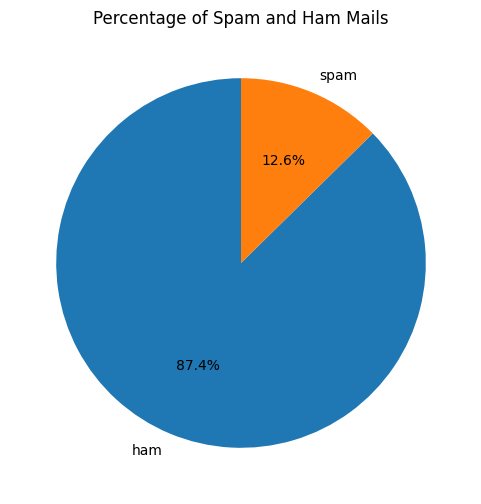

In [23]:
# Percentage of spam and ham mails
plt_data = df.Label.value_counts()
plt.figure(figsize=(14,6))
plt.title('Percentage of Spam and Ham Mails')
plt.pie(plt_data, labels=plt_data.index, autopct='%.1f%%', startangle=90)
plt.show()

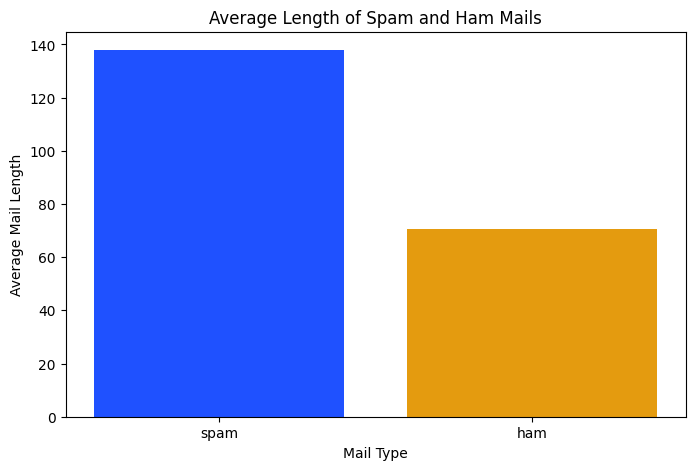

In [24]:
# Average Length of Spam and Ham Mails
plt_data = df.groupby('Label')['Email_length'].mean().sort_values(ascending=False)
plt.figure(figsize=(8,5))
plt.title('Average Length of Spam and Ham Mails')
plt.bar(plt_data.index, plt_data.values, color= ['#1F51FF', '#E49B0F'])
plt.xlabel('Mail Type')
plt.ylabel('Average Mail Length')
plt.show()

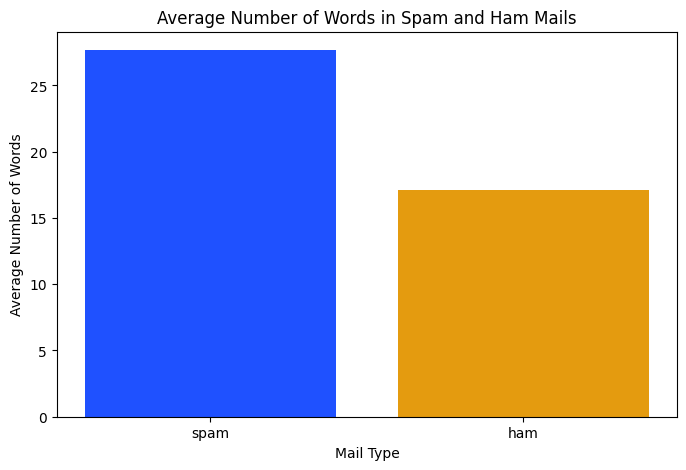

In [25]:
# Average Number of Words in Spam and Ham Mails
plt_data = df.groupby('Label')['Length_of_Words'].mean().sort_values(ascending=False)
plt.figure(figsize=(8,5))
plt.title('Average Number of Words in Spam and Ham Mails')
plt.bar(plt_data.index, plt_data.values, color= ['#1F51FF', '#E49B0F'])
plt.xlabel('Mail Type')
plt.ylabel('Average Number of Words')
plt.show()

The next step in the exploration process is to see if there's a correlation between the email length and number of words and the Spam or Ham status. to do this, the Label column needs to be transformed to a numerical column. This would be done using the Label Encoder

In [26]:
encoder = LabelEncoder()
data = df.copy()
data['Label'] = encoder.fit_transform(data['Label'])

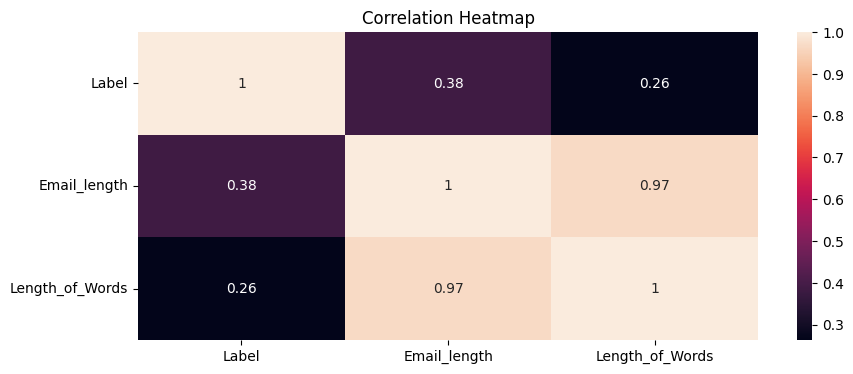

In [27]:
# correlation
corr = data.corr(numeric_only= True)
plt.figure(figsize=(10,4))
sns.heatmap(corr, annot=True)
plt.title('Correlation Heatmap')
plt.show()

__INSIGHTS__

- The Heatmap shows a strong, positive correlation between the email length and number of words, suggesting that longer emails tend to contain more words, which of course, makes sense.

- The correlation also shows a weak correlation between the email length and number of words and the Spam or Ham label. This shows that these factors are not strong enough in themselves to determine if an email would be either Spam or Ham.



### EMAIL PREPROCESSING

To prepare the emails for further analysis and modeling, a function would be defined to clean the mails. This would include:

- converting the words to lower case

- puctuation removal using regular expression

- word tokenization

- stop words removal, and

- Lemmatization, to convert the words to their base form


In [28]:
Lemmatizer = WordNetLemmatizer()
en_stopwords = stopwords.words('english')

In [29]:
# defining a function to clean the mails:

def clean(email):
  email = email.lower() #converting the words to lower case
  clean_email = re.sub('[^a-z1-9 ]', '', email) #punctuation removal

  # tokens
  temp= []

  tokens= word_tokenize(clean_email)
  for token in tokens:
    if token not in en_stopwords: #stopwords removal
       temp.append(Lemmatizer.lemmatize(token)) #Lemmatizing

  return ' '.join(temp)


In [30]:
# defining x and y
x = df['Email']
y = df['Label']

In [31]:
x.head()

,Email
0,"Go until jurong point, crazy.. Available only ..."
1,Ok lar... Joking wif u oni...
2,Free entry in 2 a wkly comp to win FA Cup fina...
3,U dun say so early hor... U c already then say...
4,"Nah I don't think he goes to usf, he lives aro..."


In [32]:
x = x.apply(clean)
print(x)

0       go jurong point crazy available bugis n great ...
1                                 ok lar joking wif u oni
2       free entry 2 wkly comp win fa cup final tkts 2...
3                     u dun say early hor u c already say
4                nah dont think go usf life around though
                              ...                        
5567    2nd time tried 2 contact u u 75 pound prize 2 ...
5568                            b going esplanade fr home
5569                           pity mood soany suggestion
5570    guy bitching acted like id interested buying s...
5571                                       rofl true name
Name: Email, Length: 5169, dtype: object


In [33]:
# adding the cleaned mails to the dataframe
df['cleaned_mails'] = x

### WORD CLOUD

__What are the most common words in Spam Emails? Let's find out__

In [34]:
# extracting the spam emails from the dataframe, returning the cleaned version
spam_emails = df[df['Label'] == 'spam']['cleaned_mails']
# splitting the emails to extract spam words
spam_words = ' '.join(spam_emails).split()
# Counting the occurence of each word
word_counts = Counter(spam_words)
# getting the most common 15 words
most_common_words = word_counts.most_common(15)
#printing the most common 15 words
print("Top 15 Words:")
for word, count in most_common_words:
    print(f"{word}: {count}")


Top 15 Words:
call: 314
2: 204
free: 188
u: 130
txt: 126
text: 120
1: 120
ur: 119
mobile: 114
4: 106
stop: 103
claim: 98
reply: 94
prize: 82
5: 69


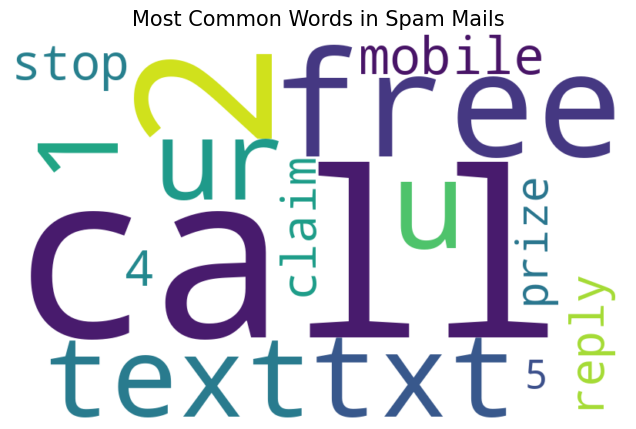

In [43]:
# generating the word cloud
wordcloud = WordCloud(width=800, height=500, background_color='white').generate_from_frequencies(dict(most_common_words))
#plotting word cloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Most Common Words in Spam Mails", fontsize= 15)
plt.axis('off')
plt.show()

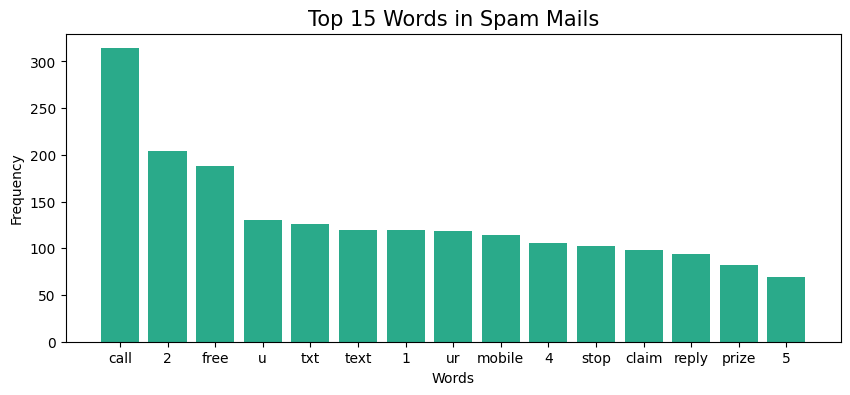

In [44]:
# Bar Chart of the Top 15 words
plt.figure(figsize=(10,4))
plt.bar(dict(most_common_words).keys(), dict(most_common_words).values(), color= '#2AAA8A')
plt.title("Top 15 Words in Spam Mails", fontsize= 15)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

### MODELING

In [45]:
# splitting the data into train and test
X_train, X_test, y_train, y_test =train_test_split(x, y, test_size= 0.2, random_state= 42)

### LABEL ENCODING AND VECTORIZATION

The next thing i'll be doing is to transform the email text data in the training dataframe into numerical vectors using the Count Vectorizer. This is to get the data into a suitable form for the machine learning algorithms. The email Label column will also be transformed to numerical values using the Label Encoder. This step is essential as machine learning algorithms work with numerical data.

In [46]:
bow_vectorizer = CountVectorizer()
encoder = LabelEncoder()

In [47]:
X_train = bow_vectorizer.fit_transform(X_train).toarray()
y_train = encoder.fit_transform(y_train)

In [48]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [49]:
y_train

array([0, 0, 0, ..., 0, 0, 1])

### MODEL TRAINING

In [50]:
log_reg = LogisticRegression()
SVC = SVC()
rf = RandomForestClassifier()
xgb = XGBClassifier()

In [51]:
log_reg.fit(X_train, y_train)

LogisticRegression()

In [52]:
SVC.fit(X_train, y_train)

SVC()

In [53]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [54]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### EVALUATING THE MODELS ON THE TEST DATASET

In [55]:
# transforming the test data
X_test = bow_vectorizer.transform(X_test).toarray()
y_test = encoder.transform(y_test)

### Logistic Regression

In [56]:
y_pred = log_reg.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[888   1]
 [ 25 120]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       889
           1       0.99      0.83      0.90       145

    accuracy                           0.97      1034
   macro avg       0.98      0.91      0.94      1034
weighted avg       0.98      0.97      0.97      1034



### Random Forest Classifier

In [57]:
y_pred = rf.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[889   0]
 [ 37 108]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       889
           1       1.00      0.74      0.85       145

    accuracy                           0.96      1034
   macro avg       0.98      0.87      0.92      1034
weighted avg       0.97      0.96      0.96      1034



### SVC

In [59]:
y_pred = SVC.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[888   1]
 [ 26 119]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       889
           1       0.99      0.82      0.90       145

    accuracy                           0.97      1034
   macro avg       0.98      0.91      0.94      1034
weighted avg       0.97      0.97      0.97      1034



__BEST PERFORMING MODEL__

- The Comparison of the Classification Reports of the Models shows the __Random Forest Classifier__ to be the best Performing model. This model correctly classified all non-spam (ham) mails with a recall percentage of a 100% , making us confident that non of our important mails would end up in the spam folder.

- Another impressive thing, is the fact that the model achieved a precision score of 100% for spam mails, for every time an email was classified as 'spam', it was actually a spam email. This implies that if an email ends up in the spam folder, we can be sure that it is actually spam.

### MODEL DEMONSTRATION

Here, we'll see a demonstration of how the trained model can be applied in real-world scenarios to classify new emails as either 'Spam' or 'Ham'. I defined a function to predict the email label, which would take a mail as an argument. This would then be transformed to an array by the Count Vectorizer, and passed to the trained model for prediction. The function would return the Predicted Label of the mail.


In [60]:
def predict_mail_label(mail):
  # vectorize the mail
  transformed_mail = bow_vectorizer.transform(mail).toarray()
  # predict the label
  prediction = rf.predict(transformed_mail)
  # print the prediction
  if prediction[0] == 1:
    print('Predicted label: This email is a Spam mail')
  else:
    print('Predicted Label: This email is Ham')

In [61]:
user_email= input('Enter the Mail: ')
predict_mail_label([user_email])

Enter the Mail: One-Stop Solution for All Your Bills!  There’s something special about a cozy night with friends😎.  Have you ever thought about how to enhance that experience with premium entertainment?   
Predicted Label: This email is Ham


In [62]:
user_email= input('Enter the Mail: ')
predict_mail_label([user_email])

Enter the Mail:  Congratulations! You're the lucky winner of an iPhone 12. Call  this number to claim your price now!
Predicted label: This email is a Spam mail
